In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
from pcrglobwb_203_30min_2way import pcrglobwb_bmi
from pcrglobwb_203_30min_2way import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import configuration

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
	inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
	use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-01-26 16:30:02,083 pcrglobwb_203_30min_2way.configuration INFO Model run started at 2018-01-26 16:30:02.079549
2018-01-26 16:30:02,084 pcrglobwb_203_30min_2way.configuration INFO Logging output to /home/jannis/PhD/data_PCR/output/2way/AMA/1d2d_DFM_codeDevelopment/log/AMA_2way_30min_kinWave_2.5km.ini_2018-01-26T16:30:02.079549.log
2018-01-26 16:30:02,085 pcrglobwb_203_30min_2way.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-01-26 16:30:02,085 pcrglobwb_203_30min_2way.currTimeStep INFO number of time steps :2557



##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  AMA_DFM_2km_1D2D.mdu
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-01-26 16:30:02.079322



2018-01-26 16:30:02,379 pcrglobwb_203_30min_2way.meteo INFO No forcing downscaling is implemented.
2018-01-26 16:30:06,833 pcrglobwb_203_30min_2way.waterBodies INFO WARNING!! Using only natural water bodies identified in the year 1900. All reservoirs in 1900 are assumed as lakes.
2018-01-26 16:30:07,992 pcrglobwb_203_30min_2way.deterministic_runner INFO Adjusting some model parameters based on given values in the ini/configuration file.
2018-01-26 16:30:07,993 pcrglobwb_203_30min_2way.deterministic_runner INFO 

Multiplier values used: 
For minSoilDepthFrac           : 0.5
For kSat (log-scale)           : 0.5
For recessionCoeff (log-scale) : 0.5
For storCap                    : 1.0
For degreeDayFactor            : 1.0
For refPotET                   : 1.0

2018-01-26 16:30:07,996 pcrglobwb_203_30min_2way.pcrglobwb_bmi INFO Model initialized. Spin-up might be required.
2018-01-26 16:30:07,997 pcrglobwb_203_30min_2way.pcrglobwb_bmi INFO Spin-Up #Total Years: 1
2018-01-26 16:30:07,998 pcrg


>>> PCR Initialized <<<



2018-01-26 16:30:08,303 pcrglobwb_203_30min_2way.meteo INFO No forcing downscaling is implemented.
2018-01-26 16:30:12,912 pcrglobwb_203_30min_2way.waterBodies INFO WARNING!! Using only natural water bodies identified in the year 1900. All reservoirs in 1900 are assumed as lakes.
2018-01-26 16:30:14,091 pcrglobwb_203_30min_2way.deterministic_runner INFO Adjusting some model parameters based on given values in the ini/configuration file.
2018-01-26 16:30:14,092 pcrglobwb_203_30min_2way.deterministic_runner INFO 

Multiplier values used: 
For minSoilDepthFrac           : 0.5
For kSat (log-scale)           : 0.5
For recessionCoeff (log-scale) : 0.5
For storCap                    : 1.0
For degreeDayFactor            : 1.0
For refPotET                   : 1.0

2018-01-26 16:30:14,095 pcrglobwb_203_30min_2way.currTimeStep INFO Spin-Up 1 of 1
2018-01-26 16:30:14,096 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-01
2018-01-26 16:30:14,262 pcrglobwb_203_30min_2way.pc

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-01-26 16:35:40,350 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
2018-01-26 16:35:40,362 bmi.wrapper INFO Loading model /home/jannis/Desktop/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM/AMA_DFM_2km_1D2D.mdu in directory /home/jannis/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM



>>>  DFM  Initialized <<<



In [9]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------
#

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl, cell_points_fm, separator_1D, cellAreaSpherical_1D, cellAreaSpherical_2D, xz_coords, yz_coords, \
					hydrodynamic_coords_1D, hydrodynamic_coords_2D = model_functions.extractModelData_DFM(hydrodynamicModel, use_RFS, use_2way)

    coupledFPindices = 0.
    print '\n>>> DFM data retrieved <<<\n'

elif model_type == 'LFP':

    #- retrieving data from LISFLOOD-FP
    dx, dy, DEM, bottom_lvl, H, waterDepth, rows, cols, \
                list_x_coords, list_x_coords_2way, list_y_coords, list_y_coords_2way, coupledFPindices, coupledFPindices_2way, grid_dA, cellAreaSpherical_1D, \
				SGCQin, separator_1D, = model_functions.extractModelData_LFP(hydrodynamicModel, model_dir, verbose_folder, use_RFS, use_2way, verbose)

    cellAreaSpherical_2D = np.copy(cellAreaSpherical_1D)

    #- computing FP-coordinates
    hydrodynamic_coords_1D = coupling_functions.getVerticesFromMidPoints(list_x_coords, list_y_coords, dx, dy, verbose)
    hydrodynamic_coords_2D = coupling_functions.getVerticesFromMidPoints(list_x_coords_2way, list_y_coords_2way, dx, dy, verbose)
    print '\n>>> LFP data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, landmask_pcr, clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> DFM data retrieved <<<


>>> PCR data retrieved <<<



In [10]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [11]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# converting single indices of coupled PCR cells to double (array,column) indices
# couple_HDYN_2_HLOG: list containing indices of all coupled hydrodynamic cells with their corresponding index of coupled hydrologic cell (one-to-one)
# couple_HLOG_2_HDYN: list containing indices of all coupled hydrologic cells with their corresponding indices of coupled hydrodynamic cells (one-to-many_
# coupled_HLOG_indices: list containing indices of all coupled PCR cells

if use_2way == False:
	# linking PCR-cells with 1D hydrodynamic cells (if use_RFS=True) or 2D hydrodynamic cells (if use_RFS=False)
    couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, hydrodynamic_coords_1D, verbose)

elif use_2way == True:
	# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
    couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, hydrodynamic_coords_1D, verbose)
	# linking PCR-cells with 2D hydrodynamic cells
    couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, hydrodynamic_coords_2D, verbose)


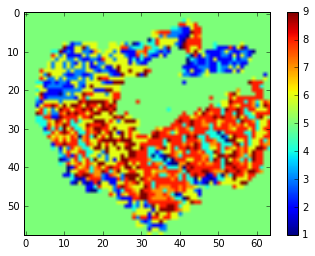

In [12]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
#
# for 1D <-> PCR
# this is required to avoid double-routing by HDYN and HLOG (as we want to perform the routing by HDYN only!)
# -------------------------------------------------------------------------------------------------

model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(hydrologicModel.get_var(('routing', 'lddMap')))
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

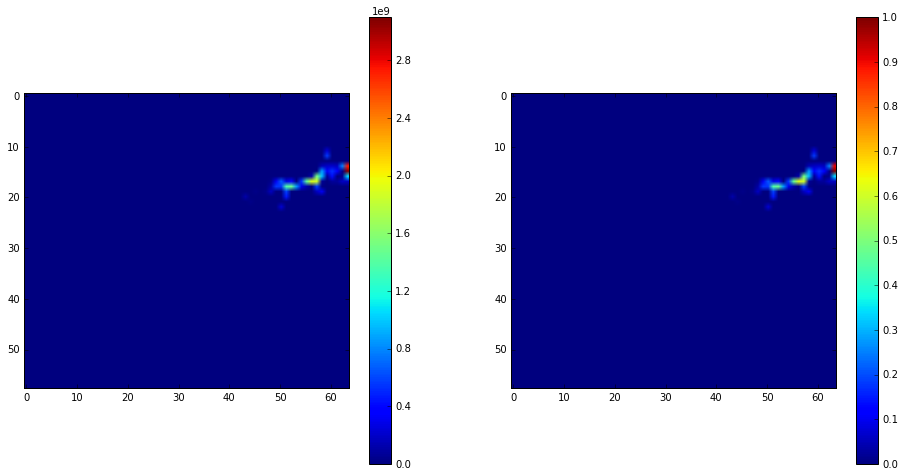

In [13]:
# -------------------------------------------------------------------------------------------------
# COMPUTING INUNDATION AS AREA AND AS FRACTION OF PCR-CELL
#
# inundatedArea_HDYN1D_2_HLOG			= list with upscaled inundated area of all 1D hydrodynamic cells within a hydrologic cell
# inundatedArea_HDYN2D_2_HLOG			= list with upscaled inundated area of all 2D hydrodynamic cells within a hydrologic cell
# inundatedArea_HDYN2D_2_HLOG_BMI		= array of upscaled inundated area of all 2D hydrodynamic cells within a hydrologic cell; to be used with BMI-command
# inundatedFraction_HDYN2D_2_HLOG		= list with fractional inundated area of all 2D hydrodynamic cells per hydrologic cell
# inundatedFraction_HDYN2D_2_HLOG_BMI	= array of fractional inundated area of all 2D hydrodynamic cells per hydrologic cell; to be used with BMI-command
# -------------------------------------------------------------------------------------------------

inundatedArea_HDYN1D_2_HLOG, inundatedArea_HDYN2D_2_HLOG, inundatedArea_HDYN2D_2_HLOG_BMI, \
			inundatedFraction_HDYN2D_2_HLOG, inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea_Hydrodynamics(model_type,
                                                                                                                                        hydrodynamicModel,
                                                                                                                                        couple_HLOG_2_HDYN,
                                                                                                                                        coupled_HLOG_indices,
																																		couple_HLOG_2_HDYN_2way,
																																		coupled_HLOG_indices_2way,
																																		threshold_inundated_depth,
																																		cellAreaSpherical_1D,
																																		cellAreaSpherical_2D,
																																		cellarea_data_pcr,
																																		landmask_pcr,
																																		missing_value_landmask)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'inundatedArea_HDYN2D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(122)
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'inundatedFraction_HDYN2D_2_HLOG_BMI.png'), dpi=300)

-603472394.802 3901294103.34


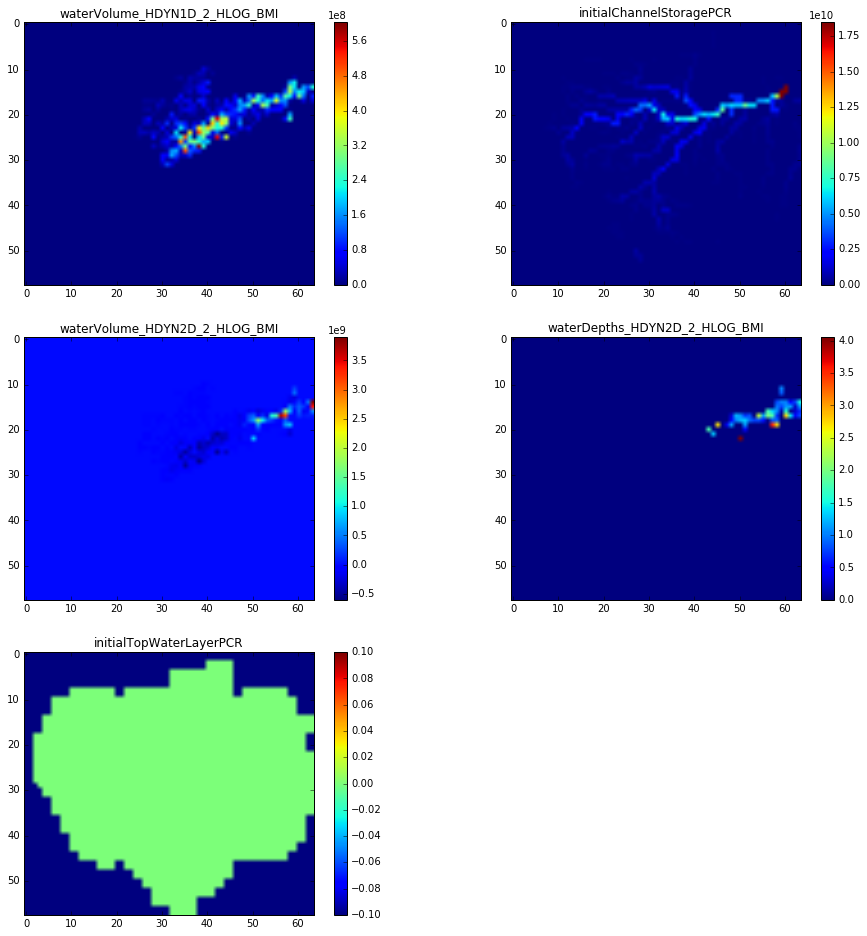

In [14]:
# -------------------------------------------------------------------------------------------------
# COMPUTING WATER VOLUME AND DEPTH TO BE COUPLED BACK TO PCR
#
# waterVolume_HDYN1D_2_HLOG_BMI		= array of accumulated water volume of all 1D hydrodynamic cells within a hydrologic cell
# waterVolume_HDYN2D_2_HLOG_BMI		= array of accumulated water volume of all 2D hydrodynamic cells within a hydrologic cell
# waterDepths_HDYN2D_2_HLOG_BMI		= array of accumulated water depth of all 2D hydrodynamic cells within a hydrologic cell (waterdepth = Vhdyn/Ainund.hdyn)
# -------------------------------------------------------------------------------------------------

waterVolume_HDYN1D_2_HLOG_BMI, waterVolume_HDYN2D_2_HLOG_BMI, waterDepths_HDYN2D_2_HLOG_BMI  = model_functions.determine_InundationDepth_Hydrodynamics(model_type,
																										hydrodynamicModel,
																										landmask_pcr,
																										missing_value_landmask,
																										inundatedArea_HDYN1D_2_HLOG,
																										inundatedArea_HDYN2D_2_HLOG,
																										couple_HLOG_2_HDYN,
																										coupled_HLOG_indices,
																										couple_HLOG_2_HDYN_2way,
																										coupled_HLOG_indices_2way)
plt.figure(figsize=(16,16))
plt.subplot(321)
plt.title('waterVolume_HDYN1D_2_HLOG_BMI')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'waterVolume_HDYN1D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(322)
plt.title('initialChannelStoragePCR')
plt.imshow(hydrologicModel.get_var('channelStorage'))
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'initialChannelStoragePCR.png'), dpi=300)
plt.subplot(323)
plt.title('waterVolume_HDYN2D_2_HLOG_BMI')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar()
print np.min(waterVolume_HDYN2D_2_HLOG_BMI), np.max(waterVolume_HDYN2D_2_HLOG_BMI)
#plt.savefig(os.path.join(verbose_folder,'waterVolume_HDYN2D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(324)
plt.title('waterDepths_HDYN2D_2_HLOG_BMI')
plt.imshow(waterDepths_HDYN2D_2_HLOG_BMI)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'waterDepths_HDYN2D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(325)
plt.title('initialTopWaterLayerPCR')
plt.imshow(hydrologicModel.get_var('topWaterLayer'), vmin=0.000)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'initialTopWaterLayer.png'), dpi=300)
plt.savefig(os.path.join(verbose_folder,'conditionsPCRbefore1stUpdate.png'), dpi=300)

0.0
0.0


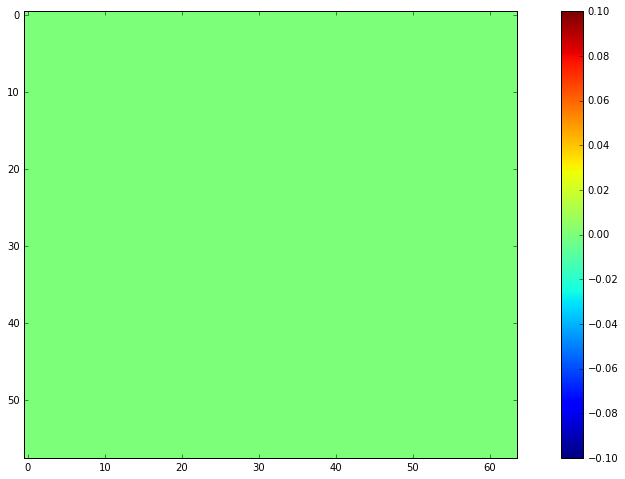

In [15]:
tWL = np.copy(hydrologicModel.get_var('topWaterLayer'))
tWL[tWL<0.] = 0

plt.figure(figsize=(16,8))
plt.imshow(tWL, vmin=0.0)
plt.colorbar()

print np.min(tWL)
print np.max(tWL)

In [16]:
print len(np.where(waterVolume_HDYN2D_2_HLOG_BMI < 0.)[0])
print np.min(waterVolume_HDYN2D_2_HLOG_BMI)

295
-603472394.802


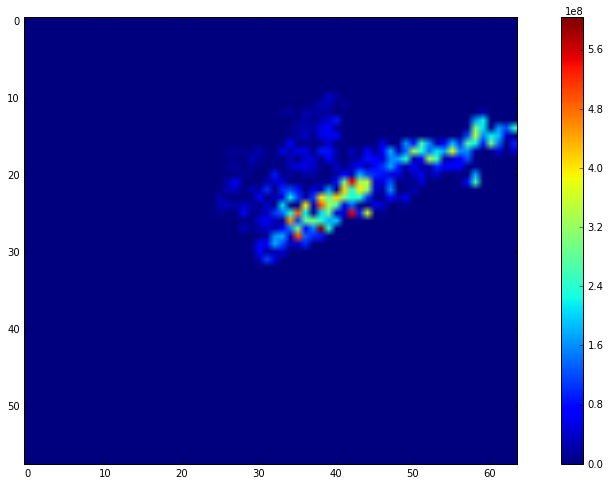

In [17]:
# -------------------------------------------------------------------------------------------------
# UPDATING CHANNELSTORAGE AND TURNING OFF WATERBODYSTORAGE
#
# for 1D HDYN <-> HLOG
# this is required to avoid the entire water volume in channels and waterbodies to empty at once into DFM/LFP
# also, channel storage in HLOG will be updated based on HDYN after first update
# -------------------------------------------------------------------------------------------------

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.imshow(hydrologicModel.get_var('channelStorage'))
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'updatedChannelStoragePCR.png'), dpi=300)

In [18]:
n = 1
for i in xrange(n):
    hydrologicModel.update(1)

2018-01-26 16:36:32,149 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-01
2018-01-26 16:36:32,456 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-01
2018-01-26 16:36:32,548 pcrglobwb_203_30min_2way.landSurface INFO WARNING! Domestic water demand is not included.
2018-01-26 16:36:32,549 pcrglobwb_203_30min_2way.landSurface INFO WARNING! Industry water demand is not included.


<pcraster._pcraster.Field object at 0x7fc391fc12f0> <pcraster._pcraster.Field object at 0x7fc391fc12f0>

TypeError: unsupported operand type(s) for /: 'Field' and 'int'

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(hydrologicModel.get_var('channelStorage'))
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'updatedChannelStoragePCR_'+str(n)+'tsteps.png'), dpi=300)

In [ ]:
n = n+4
for i in xrange(n):
    hydrologicModel.update(1)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(hydrologicModel.get_var('channelStorage'))
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'updatedChannelStoragePCR_'+str(n)+'tsteps.png'), dpi=300)

In [ ]:
print np.min(waterDepths_HDYN2D_2_HLOG_BMI)
print np.max(waterDepths_HDYN2D_2_HLOG_BMI)

In [ ]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepths_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

testWD = hydrologicModel.get_var(('grassland','floodplainWaterLayer'))

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(hydrologicModel.get_var(('grassland','floodplainWaterLayer')), vmin=0)
plt.colorbar()
plt.subplot(122)
plt.imshow(hydrologicModel.get_var(('forest','floodplainWaterLayer')), vmin=0)
plt.colorbar()

bla = np.copy(hydrologicModel.get_var(('grassland','floodplainWaterLayer')))
print len(np.where(bla != waterDepths_HDYN2D_2_HLOG_BMI)[0])
bla[bla==-999.]=0
diff = bla - waterDepths_HDYN2D_2_HLOG_BMI
print np.max(diff), np.min(diff)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(hydrologicModel.get_var(('grassland','inundatedFraction')), vmin=0, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(hydrologicModel.get_var(('forest','inundatedFraction')), vmin=0, vmax=1)
plt.colorbar()

bla = np.copy(hydrologicModel.get_var(('grassland','inundatedFraction')))
print len(np.where(bla != inundatedFraction_HDYN2D_2_HLOG_BMI)[0])
diff = bla - inundatedFraction_HDYN2D_2_HLOG_BMI
print np.max(diff), np.min(diff)


In [ ]:
n = 1
for i in xrange(n):
    hydrologicModel.update(1)

In [ ]:
tWL = hydrologicModel.get_var('topWaterLayer')
tWL[tWL<0.] = 0

plt.figure(figsize=(16,8))
plt.imshow(tWL, vmin=0)
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'topWaterLayer_updated.png'), dpi=300)

print np.max(tWL)
print np.min(tWL)